Each headline corresponds with a stock symbol (currently only tracking US markets - companies represented by the NASDAQ and DJIA) and a sentiment label. The sentiment labels are as follows:<br>

0 -> The stock went down by market close the day the article was published (negative)<br>

1 -> The stock went up by market close the day the article was published (positive)<br>

2 -> The stock stayed the same by market close the day the article was published (neutral)

**Goal :  create a Word2Vec model which can provide a market sentiment form input news feed provided by user**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# show all rows & columns , not required here
# pd.pandas.set_option("display.max_rows",None)
# pd.pandas.set_option("display.max_columns",None)

In [8]:
#importing the dija & nasdaq dataframe
# df_dija=pd.read_csv('../input/news-sentiment-analysis-for-stock-data-by-company/djia_news copy.csv/djia_news copy.csv',encoding = "ISO-8859-1")
# df_nasdaq=pd.read_csv('../input/news-sentiment-analysis-for-stock-data-by-company/nasdaq.csv/nasdaq.csv',encoding = "ISO-8859-1")
df = pd.read_csv("data/NEWS_YAHOO_stock_prediction.csv")

In Us stock market dija(Dow Jones Industrial Average) list 30 prominent companies and nasdaq(National Association of Securities Dealers Automated Quotations) refer to all company listed in NYSE(New York Stock Exchange) , Nasdaq is also the name of the Stck exchage.

Previously DIJA index was used for Industry heavy companies & NASDAQ was for tech,internet based companies but now that is not the case anymore


**Hypothesis : Combining both Nasdaq & The Dow will give holistic view of the market , so I've combined both of dija & nasdaq (whether training them separately will give better model or not that needs to be tested)**

In [9]:
df.head(5)

,Unnamed: 0,ticker,Date,category,title,content,Open,High,Low,Close,Adj Close,Volume,label
0,0,AAPL,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
1,1,AAPL,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
2,2,AAPL,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
3,3,AAPL,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
4,4,AAPL,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15975 entries, 0 to 15974
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15975 non-null  int64  
 1   ticker      15975 non-null  object 
 2   Date        15975 non-null  object 
 3   category    15975 non-null  object 
 4   title       15975 non-null  object 
 5   content     15975 non-null  object 
 6   Open        15975 non-null  float64
 7   High        15975 non-null  float64
 8   Low         15975 non-null  float64
 9   Close       15975 non-null  float64
 10  Adj Close   15975 non-null  float64
 11  Volume      15975 non-null  int64  
 12  label       15975 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 1.6+ MB


In [11]:
#counting cumulative frequency of labels : 1 - positive , 0 - negative , 2- neutral
df.groupby(by='ticker').count()

,Unnamed: 0,Date,category,title,content,Open,High,Low,Close,Adj Close,Volume,label
ticker,,,,,,,,,,,,
AAPL,15975,15975,15975,15975,15975,15975,15975,15975,15975,15975,15975,15975


Quite a large number of label valus , so we need answers for . 
1. Is there any duplicate headline ?
2. If there is duplicate,does market behave in a consistent manner when it encounters these headline ?

In [12]:
#separating unique & duplicate values , storing them in different dataframe
df_dup=df[df.duplicated('content',keep=False)].sort_values('content')
df_dup.head(30)
df_dup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 2794 to 7417
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  33 non-null     int64  
 1   ticker      33 non-null     object 
 2   Date        33 non-null     object 
 3   category    33 non-null     object 
 4   title       33 non-null     object 
 5   content     33 non-null     object 
 6   Open        33 non-null     float64
 7   High        33 non-null     float64
 8   Low         33 non-null     float64
 9   Close       33 non-null     float64
 10  Adj Close   33 non-null     float64
 11  Volume      33 non-null     int64  
 12  label       33 non-null     int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 3.6+ KB


In [13]:
df_unique=df[~df.duplicated('content',keep=False)].sort_values('content')
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15942 entries, 9707 to 14165
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15942 non-null  int64  
 1   ticker      15942 non-null  object 
 2   Date        15942 non-null  object 
 3   category    15942 non-null  object 
 4   title       15942 non-null  object 
 5   content     15942 non-null  object 
 6   Open        15942 non-null  float64
 7   High        15942 non-null  float64
 8   Low         15942 non-null  float64
 9   Close       15942 non-null  float64
 10  Adj Close   15942 non-null  float64
 11  Volume      15942 non-null  int64  
 12  label       15942 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 1.7+ MB


In [14]:
# now counting number of sentiments(+ve,-ve and neutral) present for each & every stock of dija
df_unique.groupby(by=['ticker','label']).count()

Unnamed: 0  Date  category  title  content  Open  High   Low  \
ticker label                                                                 
AAPL   0            7117  7117      7117   7117     7117  7117  7117  7117   
       1            8825  8825      8825   8825     8825  8825  8825  8825   

              Close  Adj Close  Volume  
ticker label                            
AAPL   0       7117       7117    7117  
       1       8825       8825    8825

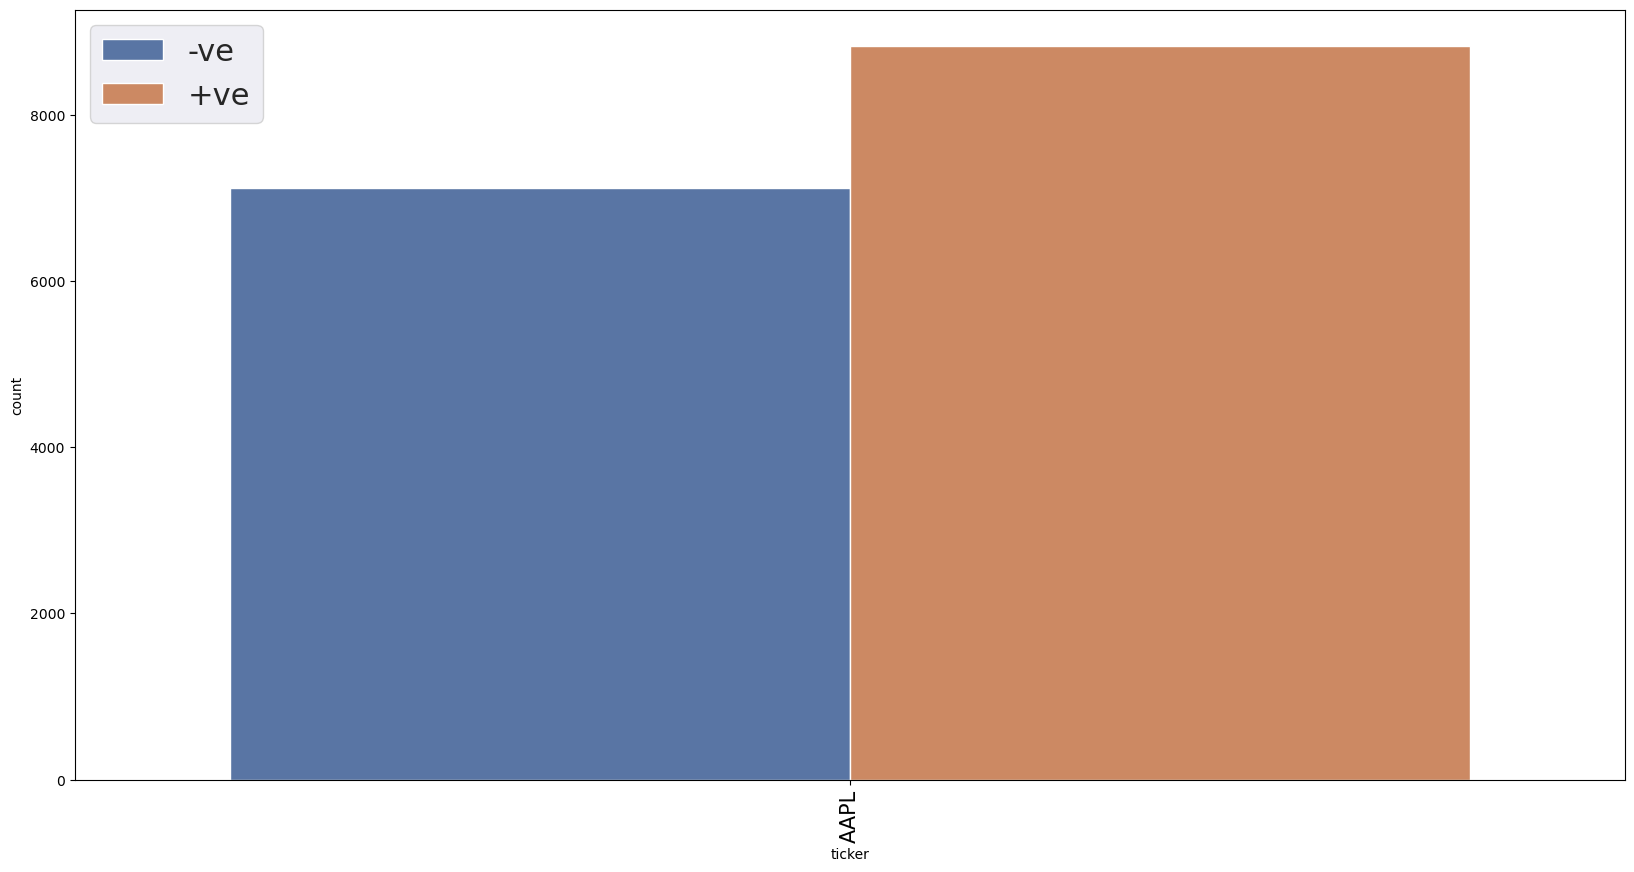

In [15]:
#plotting distribution of unique values
fig,ax=plt.subplots(1,1,figsize=(20,10))
sns.set(font_scale = 2)
plt.xticks(rotation=90,fontsize=15)
sns.countplot(x=df_unique['ticker'],hue=df_unique['label'])
ax.legend(['-ve','+ve'])
plt.show()

In [16]:
#categorize each sentiments (+ve,-ve) for AAPL
df_word=df.groupby(by=['label'])['content'].apply(' '.join).reset_index()
df_word.head(10)

,label,content
0,0,Technology giant Apple NASDAQ AAPL is set ...
1,1,Advanced Micro Devices NASDAQ AMD fourth q...


In [17]:
from wordcloud import WordCloud, STOPWORDS

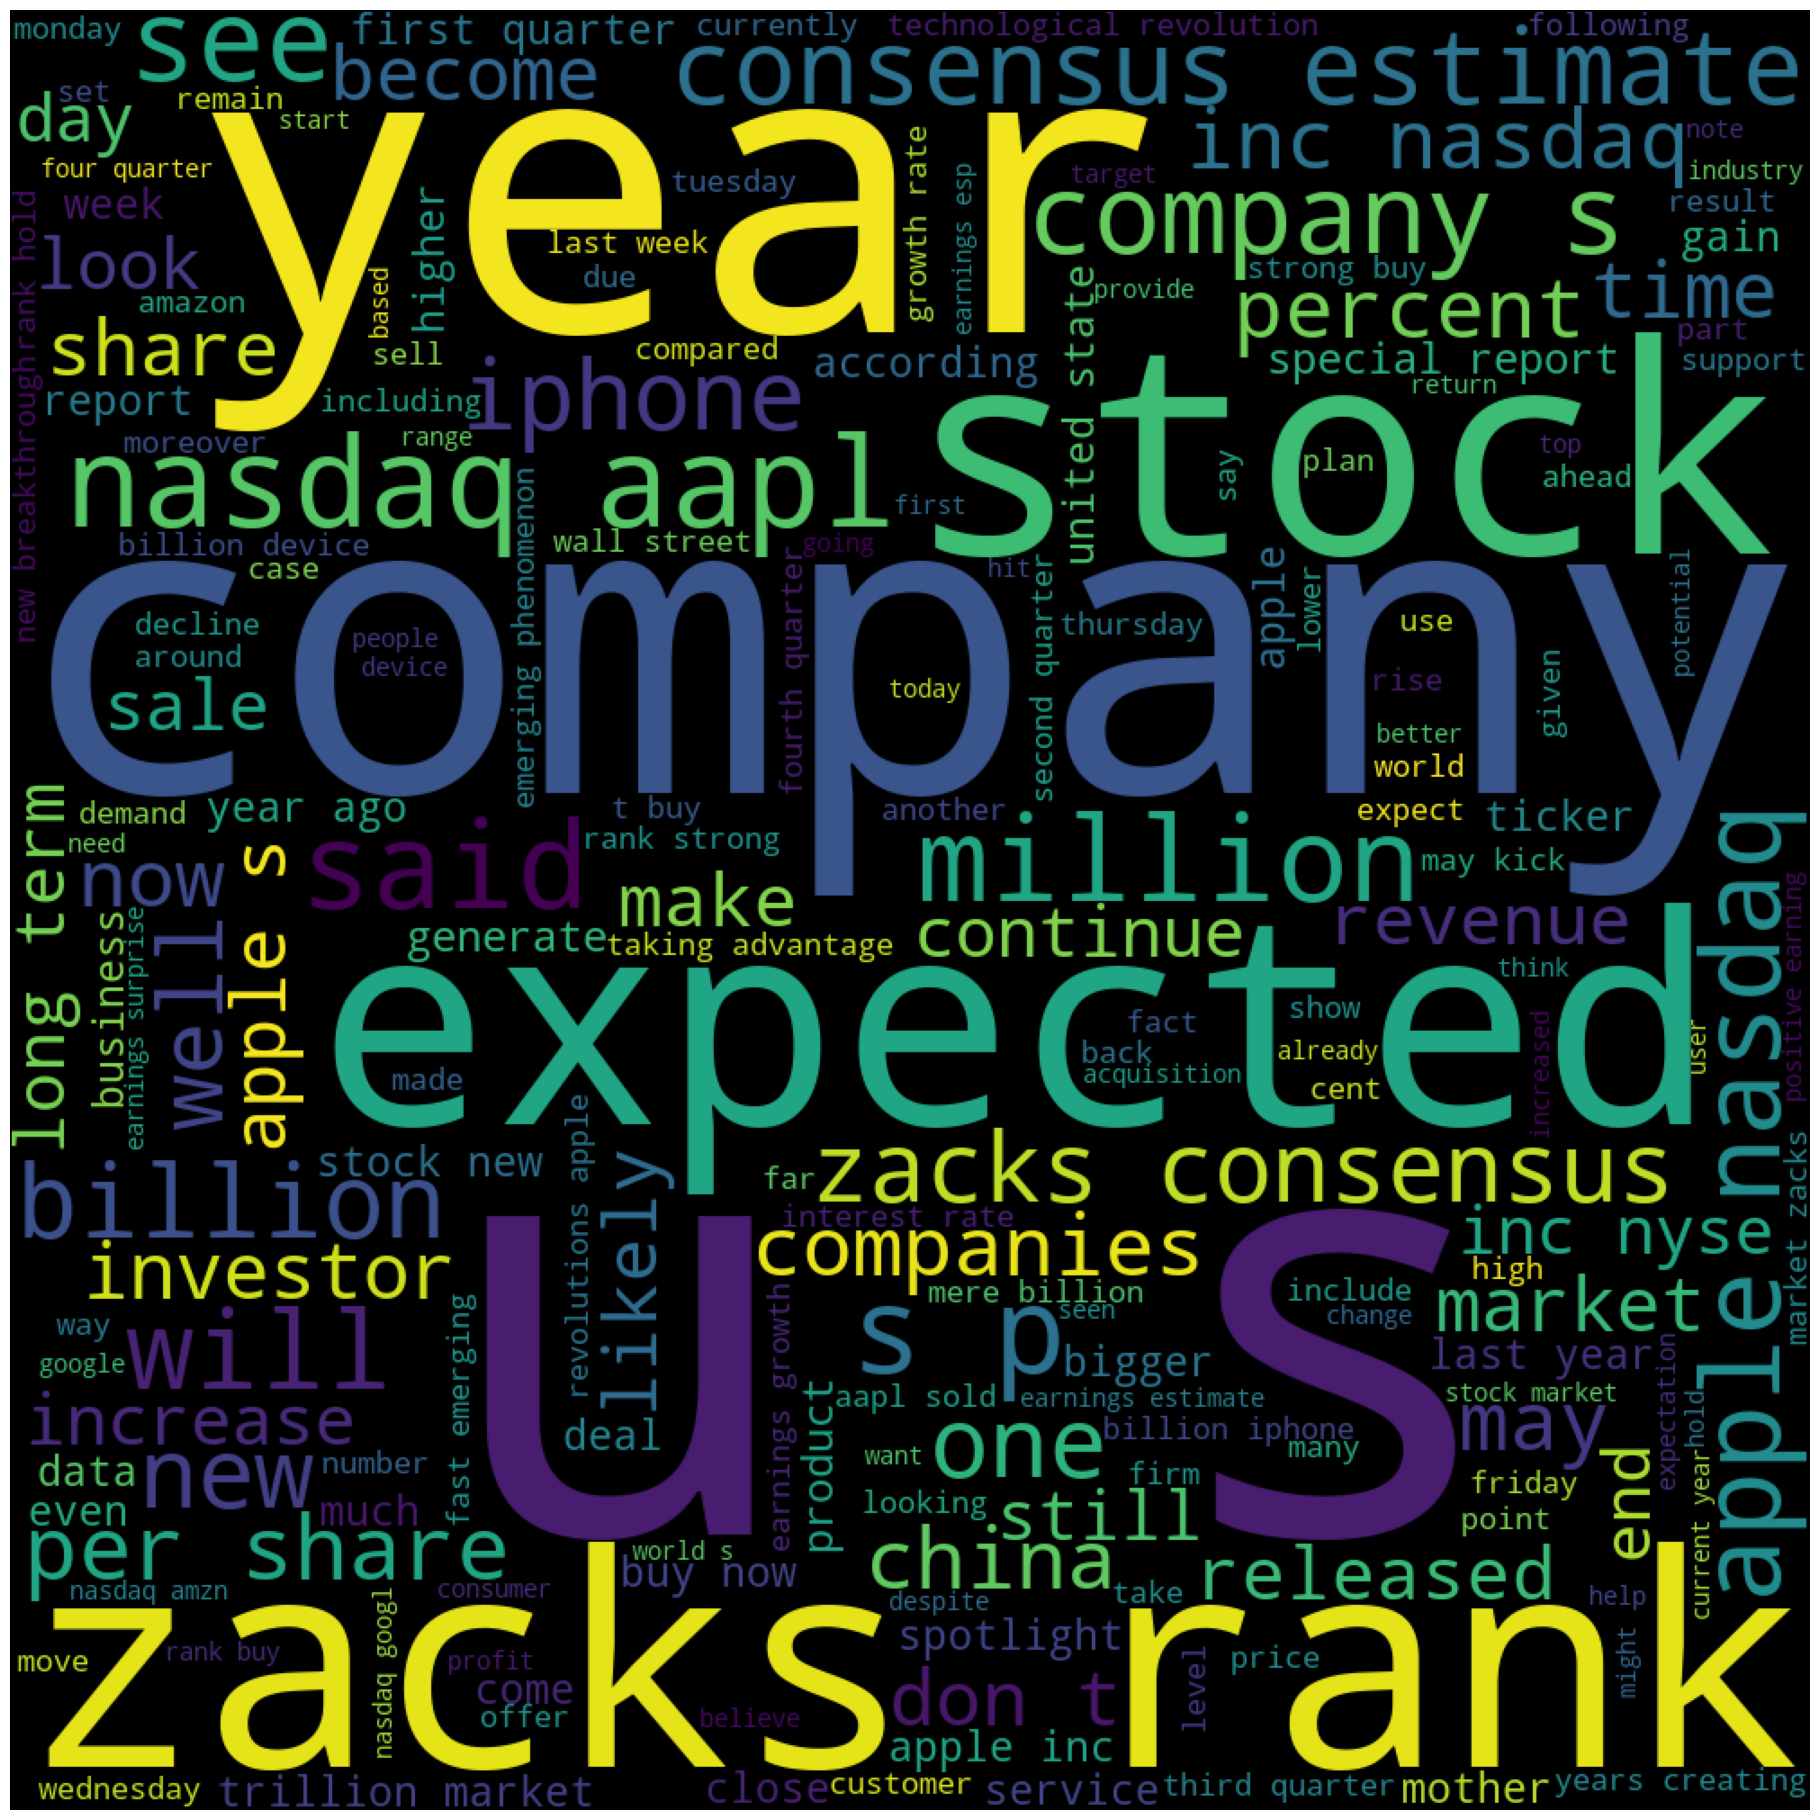

In [18]:
# let's check which words are causing havoc or creating opportunity
comment_words = ''
stopwords = set(STOPWORDS)

for val in df_word['content'].str.lower():
    tokens = val.split()
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 1000, height = 1000,background_color ='black',
                stopwords = stopwords,min_font_size = 10).generate(comment_words)
 
                     
plt.figure(figsize = (18, 18), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [19]:
#combine all sentiments into 2 groups (+ve,-ve) based on headline
def combine_text(data):
    headline0=[] # list to store -ve healine
    headline1=[] # list to store +ve healine
    for i in range(len(data)):
        label=data.iloc[i,0] # fix to 0 & 1
        headline=data.iloc[i,1].lower()
        # we compare the levels & store to corresponding list
        if label==0:
            headline0.append(''.join(str(x)for x in headline))
        elif label==1:
            headline1.append(''.join(str(x)for x in headline))
    
    # convert list to text & storing them inside another list so we can access it by index
    sentence_list=[]
    if len(headline0)>0:
        text0=(''.join(str(x)for x in headline0))
        sentence_list.append(text0)
    if len(headline1)>0:
        text1=(''.join(str(x)for x in headline1))
        sentence_list.append(text1)
    
    return sentence_list

In [20]:
df_unique=df[~df.duplicated('content',keep=False)].sort_values('content')
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15942 entries, 9707 to 14165
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15942 non-null  int64  
 1   ticker      15942 non-null  object 
 2   Date        15942 non-null  object 
 3   category    15942 non-null  object 
 4   title       15942 non-null  object 
 5   content     15942 non-null  object 
 6   Open        15942 non-null  float64
 7   High        15942 non-null  float64
 8   Low         15942 non-null  float64
 9   Close       15942 non-null  float64
 10  Adj Close   15942 non-null  float64
 11  Volume      15942 non-null  int64  
 12  label       15942 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 1.7+ MB


In [21]:
whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')

In [22]:
#perform text cleaning 
def tokenize_text(sentences):
    stop = set()
    for i in range(len(sentences)):
        # remove non-letter
        sentences[i] = ''.join(filter(whitelist.__contains__, sentences[i]))
        #splits the headline text into sentences
        sentences[i]=nltk.sent_tokenize(sentences[i])
        #remove article,verb,conjunction etc. & convert it to root form of the word
        sentences[i] = [nltk.word_tokenize(sentence) for sentence in sentences[i]]
        #remove stop words
        for j in range(len(sentences[i])):
            sentences[i][j] = [word for word in sentences[i][j] if word not in stopwords.words('english')]
    return sentences

**run below cell twice to make sure stopwords have been downloaded properly, otherwise it won't be able to find stopword & give error**

In [23]:
import nltk
# nltk.download()
from nltk.corpus import stopwords

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [24]:
from gensim.models import Word2Vec

In [25]:
df_word.head(2)

,label,content
0,0,Technology giant Apple NASDAQ AAPL is set ...
1,1,Advanced Micro Devices NASDAQ AMD fourth q...


In [26]:
print(df_word.iloc[1,0])

1


In [29]:
# Word2vec model demo
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
             ['this', 'is', 'the', 'second', 'sentence'],
             ['yet', 'another', 'sentence'],
             ['one', 'more', 'sentence'],
             ['and', 'the', 'final', 'sentence']]
model = Word2Vec(sentences, min_count=1)
# print(model.wv['sentence'])  # 获取 'sentence' 这个词的向量
print(model.wv.most_similar('sentence'))  # 找出与 'sentence' 最相似的词

[('yet', 0.21617332100868225), ('for', 0.09310111403465271), ('one', 0.09291721880435944), ('word2vec', 0.07963486760854721), ('second', 0.06285078823566437), ('another', 0.027057476341724396), ('more', 0.016134683042764664), ('the', -0.010839177295565605), ('final', -0.027750369161367416), ('first', -0.041253410279750824)]


In [32]:
#df['Headline'].replace("[^a-zA-Z]"," ",regex=True, inplace=True)
sentences=combine_text(df_word)
sentences=tokenize_text(sentences)

[[['technology',
   'giant',
   'apple',
   'nasdaq',
   'aapl',
   'set',
   'release',
   'first',
   'quarter',
   'fiscal',
   'results',
   'jan',
   'market',
   'close',
   'since',
   'apple',
   'accounts',
   'total',
   'market',
   'capitalization',
   'entire',
   'technology',
   'sector',
   'p',
   'index',
   'worth',
   'taking',
   'look',
   'fundamentals',
   'ahead',
   'quarterly',
   'results',
   'apple',
   'hitting',
   'record',
   'highs',
   'lately',
   'returned',
   'past',
   'three',
   'months',
   'par',
   'industry',
   'gain',
   'momentum',
   'expected',
   'continue',
   'company',
   'beats',
   'estimates',
   'soon',
   'reported',
   'quarter',
   'read',
   'inside',
   'methodologyapple',
   'zacks',
   'rank',
   'buy',
   'according',
   'methodology',
   'combination',
   'positive',
   'earnings',
   'esp',
   'zacks',
   'rank',
   'strong',
   'buy',
   'buy',
   'hold',
   'increases',
   'chances',
   'earnings',
   'beat',
   'u

In [ ]:
sentences[0]

In [ ]:
models=[] # store Word2Vec model
words=[] # store vocabulary corresponding to each model
#each step calculating a model corresponding to each sentiment label (-ve,_ve,neutral consecutively)
for i in range(len(sentences)):
    print(f"Running model : {i}")
    model=Word2Vec(sentences[i], min_count=1)
    models.append(model)
    # store vocab for this model
    words.append(list(model.wv.index_to_key))

Running model : 0
Running model : 1


In [27]:
models=[] # store Word2Vec model
words=[] # store vocabulary corresponding to each model
#each step calculating a model corresponding to each sentiment label (-ve,_ve,neutral consecutively)
for i in range(len(sentences)):
    print(f"Running model : {i}")
    model=Word2Vec(sentences[i], min_count=1)
    models.append(model)
    # store vocab for this model
    words.append(list(model.wv.index_to_key))

Running model : 0
Running model : 1


In [33]:
len(sentences)

2

In [35]:
words[0][:10]

['year',
 'apple',
 'company',
 'nasdaq',
 'zacks',
 'market',
 'earnings',
 'billion',
 'quarter',
 'stock']

In [36]:
words[1][:10]

['year',
 'company',
 'apple',
 'zacks',
 'earnings',
 'nasdaq',
 'market',
 'quarter',
 'billion',
 'stock']

In [37]:
#testing 
models[1].wv.doesnt_match("france england germany berlin".split())

'france'

output interpretation : <br>
england - outside Europe unlike other 3<br>
berline - city, capital of germany , not a country <br>
france/germany - belong to Europe & country

In [ ]:
# testing - goldman sach was a part of orginal data
similar = models[0].wv.most_similar('goldman')
print(similar)

[('departures', 0.38467538356781006), ('flmbjulmftla', 0.382993221282959), ('klan', 0.37168198823928833), ('hgflnnlhnxtrmyfixthdmb', 0.3625514805316925), ('fk', 0.36166417598724365), ('waukee', 0.3556622266769409), ('outnumbering', 0.35480797290802), ('treasurys', 0.3524662256240845), ('qzwfenhrscfhr', 0.35244372487068176), ('pressurising', 0.3515065312385559)]


In [ ]:

#preprocessing for custom text
def custom_tokenizer(text):
    text = ''.join(filter(whitelist.__contains__, text))
    text = text.lower()
    sentences = nltk.sent_tokenize(text)
    sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    for i in range(len(sentences)):
        sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]
    return sentences

In [ ]:
from textblob import TextBlob
# using textblob to print the sentiment polarity
def plot_sentiment_polarity(data):
    plt.figure(figsize=(10,10))
    plt.xlabel('sentiment')
    plt.ylabel('frequency')
    plt.hist(data, bins=20)
    plt.title('Sentiment Polarity Distribution')
    plt.show()

In [ ]:
# displays the similary or dissimilary if found any for a unidentified(sentiment not known) news headline
def check_sentiment(text):
    sentences=custom_tokenizer(text)
    print(f"Tokenized text : {sentences}")
    data=pd.DataFrame(sentences)
    data=data.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    plot_sentiment_polarity(data)
    for w in sentences:
        for i in range(len(models)):
            try:
                similar=models[i].wv.most_similar(w)
                print(f"Similarity Score for {i}-th trend :")
                for element in similar:
                    print(element)
                dissimilar= models[i].wv.doesnt_match(text.split())
                print(f"Dissimilarity Score for {i}-th trend : {dissimilar}")
            except:
                print(f"similarity/Dissimilarity with {w} not found against model {i}")
                continue

Tokenized text : [['stockmarket', 'bottom', 'pros', 'say', 'sp', 'tests']]


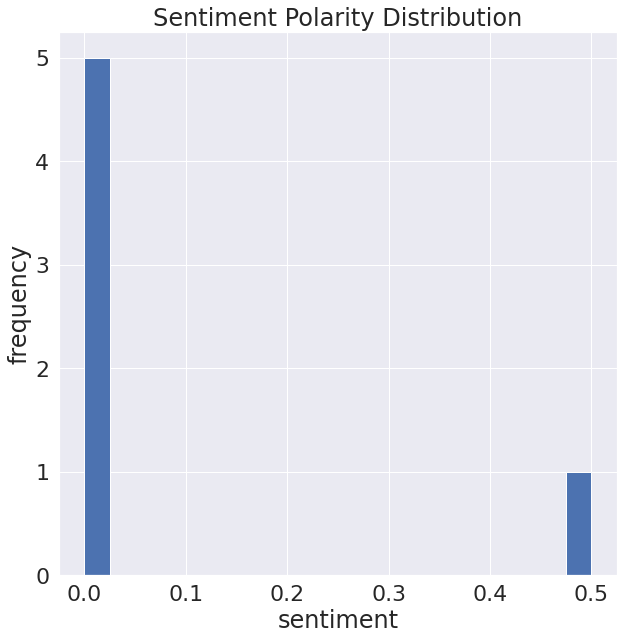

Similarity Score for 0-th trend :
('headsetstocks', 0.39915528893470764)
('provoke', 0.3787277340888977)
('posing', 0.3766016364097595)
('organic', 0.36921608448028564)
('woos', 0.3654153645038605)
('door', 0.35669443011283875)
('protect', 0.3554105758666992)
('burnley', 0.3426719307899475)
('pinterest', 0.3377099335193634)
('thesis', 0.33727896213531494)
Dissimilarity Score for 0-th trend : say
similarity/Dissimilarity with ['stockmarket', 'bottom', 'pros', 'say', 'sp', 'tests'] not found against model 1
similarity/Dissimilarity with ['stockmarket', 'bottom', 'pros', 'say', 'sp', 'tests'] not found against model 2


In [ ]:
text="Is the stock-market bottom in? What the pros say after S&P 500 tests 4,000."
check_sentiment(text)

high -ve sentiment with some +ve shift ( Dissimilarity Score for 0-th trend : say ) despite of news being overall neutral to +ve , market participants are not showing confidence on the news or overall market situation 

Tokenized text : [['wall', 'street', 'closes', 'higher', 'boosted', 'strong', 'tesla', 'earnings']]


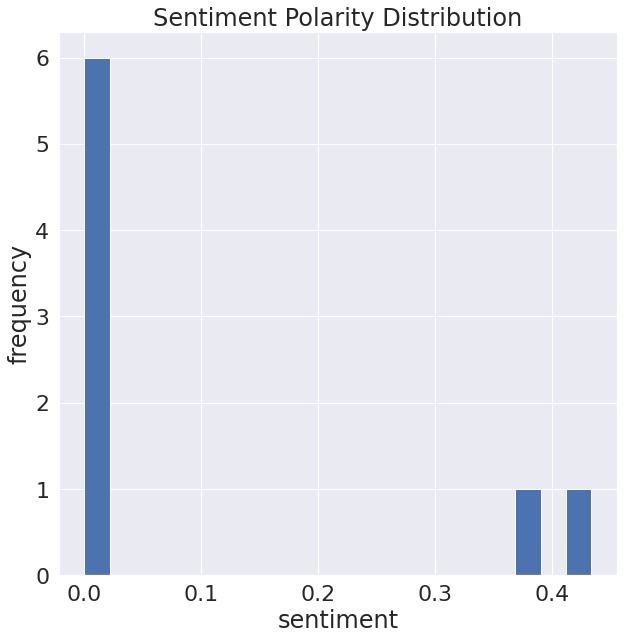

Similarity Score for 0-th trend :
('owner', 0.3952910900115967)
('recipe', 0.3883722722530365)
('financial', 0.35103699564933777)
('sohna', 0.33631041646003723)
('gumtree', 0.33067503571510315)
('reward', 0.3246820569038391)
('alot', 0.32453539967536926)
('regains', 0.324158638715744)
('bancorp', 0.3237854838371277)
('xoa', 0.32108309864997864)
Dissimilarity Score for 0-th trend : boosted
Similarity Score for 1-th trend :
('youtube', 0.38820961117744446)
('rules', 0.36936721205711365)
('american', 0.36555352807044983)
('airbase', 0.361858069896698)
('arcam', 0.352374404668808)
('homegrown', 0.3419117033481598)
('demonstration', 0.33979782462120056)
('marc', 0.3385811448097229)
('diamondback', 0.33774828910827637)
('hawaiian', 0.3364017605781555)
Dissimilarity Score for 1-th trend : closes
similarity/Dissimilarity with ['wall', 'street', 'closes', 'higher', 'boosted', 'strong', 'tesla', 'earnings'] not found against model 2


In [ ]:
text="Wall Street closes higher boosted by strong Tesla earnings"
check_sentiment(text)

we can see both -ve sentiment (model-0) & +ve sentiment (model-1) based on similarity score<br>
we can see slight +ve sentiment in between -ve trends ( Dissimilarity Score for 0-th trend : boosted )<br>
we see slight -ve sentiment in between +ve trends (Dissimilarity Score for 1-th trend : closes)<br>

Here we can see market participants are buying the news i.e they're agreeing with the news and showing +ve sentiment

Tokenized text : [['weekend', 'reads', 'prepare', 'big', 'week', 'crucial', 'federal', 'reserve', 'decision', 'techcompany', 'earnings', 'gdp', 'report']]


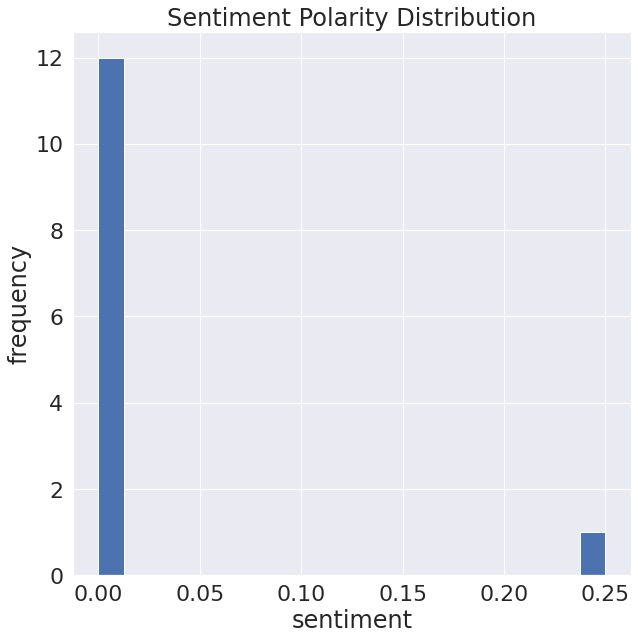

similarity/Dissimilarity with ['weekend', 'reads', 'prepare', 'big', 'week', 'crucial', 'federal', 'reserve', 'decision', 'techcompany', 'earnings', 'gdp', 'report'] not found against model 0
similarity/Dissimilarity with ['weekend', 'reads', 'prepare', 'big', 'week', 'crucial', 'federal', 'reserve', 'decision', 'techcompany', 'earnings', 'gdp', 'report'] not found against model 1
similarity/Dissimilarity with ['weekend', 'reads', 'prepare', 'big', 'week', 'crucial', 'federal', 'reserve', 'decision', 'techcompany', 'earnings', 'gdp', 'report'] not found against model 2


In [ ]:
text="Weekend reads: Prepare for a big week — a crucial Federal Reserve decision, tech-company earnings and a gdp report"
check_sentiment(text)

no similarity or dissimilary found

Tokenized text : [['apple', 'pay', 'million', 'settlement', 'butterfly', 'keyboard', 'lawsuit']]


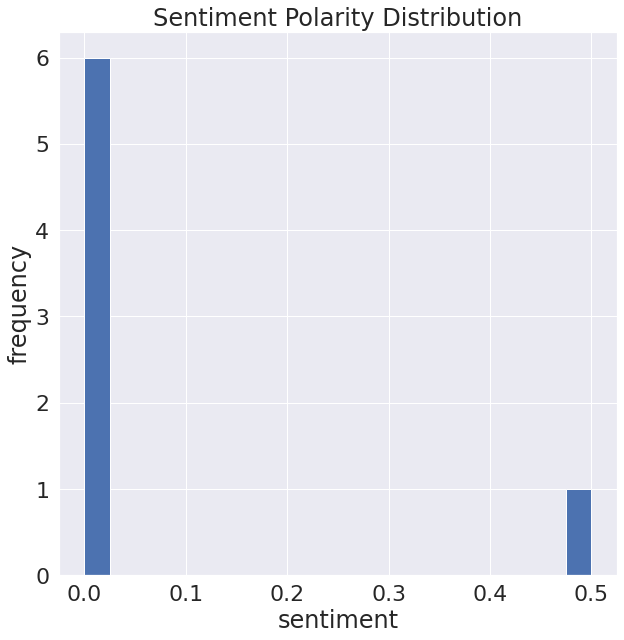

similarity/Dissimilarity with ['apple', 'pay', 'million', 'settlement', 'butterfly', 'keyboard', 'lawsuit'] not found against model 0
similarity/Dissimilarity with ['apple', 'pay', 'million', 'settlement', 'butterfly', 'keyboard', 'lawsuit'] not found against model 1
similarity/Dissimilarity with ['apple', 'pay', 'million', 'settlement', 'butterfly', 'keyboard', 'lawsuit'] not found against model 2


In [ ]:
text="Apple to Pay $50 Million Settlement Over Butterfly Keyboard Lawsuit "
check_sentiment(text)

it seems strange either no one cares about the news or people doesn't care about it , while the news is a bad hit for apple , it's a good news for owner of butterfly keyboard owner (that might be the case TextBlob is showing +ve sentiment polarity)

Tokenized text : [['ibm', 'apple', 'jnj', 'tuesdays', 'stock', 'market', 'movers']]


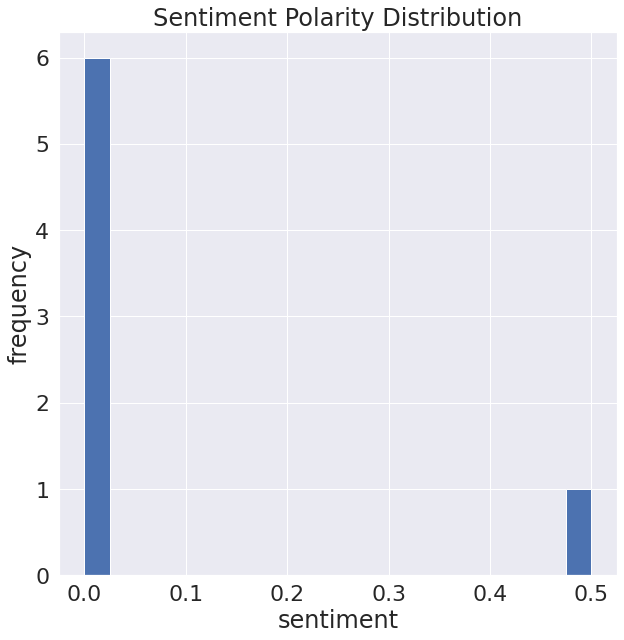

similarity/Dissimilarity with ['ibm', 'apple', 'jnj', 'tuesdays', 'stock', 'market', 'movers'] not found against model 0
similarity/Dissimilarity with ['ibm', 'apple', 'jnj', 'tuesdays', 'stock', 'market', 'movers'] not found against model 1
similarity/Dissimilarity with ['ibm', 'apple', 'jnj', 'tuesdays', 'stock', 'market', 'movers'] not found against model 2


In [ ]:
text="IBM, Apple, JNJ, and More of Tuesday's Stock Market Movers"
check_sentiment(text)

Possibly same situation as above

We can see the accuracy is not too great , perhaps BERT may produce better result but that is resource intensive too